In [1]:
from time import perf_counter
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial
from collections import defaultdict
from pathlib import Path
from typing import Tuple

import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import ImageDraw, Image
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

RS = 47
IMAGE_SIZE = (256, 256)  # (height, width)
CORES = mp.cpu_count()

np.random.seed(RS)

2023-05-30 16:56:30.687965: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 16:56:31.558672: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def get_norm_image_and_face_box(row: pd.Series, root_dir: Path) -> Tuple[np.ndarray, np.ndarray]:    
    """
    Function to normalize the image and get the face bounding box coordinates.
    
    Parameters:
    row (pd.Series): A row from a DataFrame containing the image name and bounding box coordinates.
    root_dir (Path): The root directory where the images are stored.
    
    Returns:
    Tuple[np.ndarray, np.ndarray]: A tuple containing the normalized image and the normalized face bounding box coordinates.
    """ 
    image = Image.open(root_dir / row['image_name'])
    width, height = image.size
    
    x0 = int((row['x0'] / width) * IMAGE_SIZE[1]) / IMAGE_SIZE[1]
    y0 = int((row['y0'] / height) * IMAGE_SIZE[0]) / IMAGE_SIZE[0]
    x1 = int((row['x1'] / width) * IMAGE_SIZE[1]) / IMAGE_SIZE[1]
    y1 = int((row['y1'] / height) * IMAGE_SIZE[0]) / IMAGE_SIZE[0]
    face_box = np.array([x0, y0, x1, y1])
    
    image = (
        image
        .convert('L')
        .resize(IMAGE_SIZE, Image.LANCZOS)
    )
    image = np.array(image) / 255.

    return image, face_box
    

# 1 face_box per 1 image
def load_dataset(df: pd.DataFrame, mode: str = "default") -> dict:
    """
    Function to load the dataset.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the image names and bounding box coordinates.
    mode (str): Mode to load the dataset. Can be either "default" or "enhanced".
    
    Returns:
    dict: A dictionary containing the images and their corresponding bounding box coordinates.
    """
    assert mode in ["default", "enhanced"]
    
    dataset = defaultdict(dict)
    
    r_d = {"default" : DATA_DIR, "enhanced": ENHANCED_IMAGES_DIR}
    step_printing = df.shape[0] // 10
    get_norm_image_and_face_box_partial = partial(get_norm_image_and_face_box, root_dir=r_d[mode])
    
    with ProcessPoolExecutor(max_workers=CORES) as executor:
        futures = {executor.submit(get_norm_image_and_face_box_partial, row): row['image_name'] for _, row in df.iterrows()}
        for future in as_completed(futures):
            index = futures[future]
            image, face_box = future.result()
            
            dataset[index].update({"image": image, "box": face_box})
            
            if len(dataset) % step_printing == 0:
                print(f"Processed {len(dataset)}/{df.shape[0]} images")
    print(f"Processed {round(len(dataset) / df.shape[0] * 100, 1)}% images")
    
    return dataset


def get_image_and_box_dataset_from_dict(data_dict: dict) -> Tuple[np.ndarray, np.ndarray]:
    """
    Function to get the image and bounding box dataset from a dictionary.
    
    Parameters:
    data_dict (dict): A dictionary containing the images and their corresponding bounding box coordinates.
    
    Returns:
    Tuple[np.ndarray, np.ndarray]: A tuple containing the images and their corresponding bounding box coordinates.
    """
    arr_img, arr_box = [], []
    
    for d in data_dict.values():
        arr_img.append(d['image'])
        arr_box.append(d['box'])
    assert len(arr_img) == len(arr_box)
    
    arr_box = np.array(arr_box)
    arr_img = np.array(arr_img)
    arr_img = np.expand_dims(arr_img, axis=-1)
    
    return arr_img, arr_box


def get_train_valid_test_by_indexes(data_dict: dict, ids: Tuple[int]) -> Tuple[np.ndarray]:
    """
    Function to get the train, validation, and test datasets by indexes.
    
    Parameters:
    data_dict (dict): A dictionary containing the images and their corresponding bounding box coordinates.
    ids (Tuple[int]): A tuple containing the indexes for the train, validation, and test datasets.
    
    Returns:
    Tuple[np.ndarray]: A tuple containing the train, validation, and test datasets.
    """
    X_train_ids, X_valid_ids, X_test_ids, y_train_ids, y_valid_ids, y_test_ids = ids
    images, face_boxes = get_image_and_box_dataset_from_dict(data_dict)

    X_train = images[X_train_ids]
    X_valid = images[X_valid_ids]
    X_test = images[X_test_ids]
    y_train = face_boxes[y_train_ids]
    y_valid = face_boxes[y_valid_ids]
    y_test = face_boxes[y_test_ids]
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test


def plot_metric(history: keras.callbacks.History, metric: str, k: int = 5) -> None:
    """
    Function to plot a metric from the training history.
    
    Parameters:
    history (keras.callbacks.History): The training history.
    metric (str): The metric to plot. Can be either 'accuracy' or 'loss'.
    k (int): The interval for the x-axis ticks.
    """
    assert metric in ['accuracy', 'loss'], "Wrong type of metric. Just use 'accuracy' or 'loss'"
    
    train_metrics = history.history[metric]
    val_metrics = history.history[f'val_{metric}']
    epochs = range(1, len(train_metrics) + 1)
    
    plt.plot(epochs, train_metrics, '-o', markersize=3, label=f"Training {metric}")
    plt.plot(epochs, val_metrics, label=f"Validation {metric}")
    
    plt.xticks([1] + [i for i in epochs if i % k == 0])
    
    plt.title(f'Training and validation {metric}')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.show()


def plot_image_with_predicted_box(model, image: np.ndarray) -> None:
    """
    Function to plot an image with its predicted bounding box.
    
    Parameters:
    model: The trained model.
    image (np.ndarray): The image to plot.
    """
    box = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    print(box)
    
    image = (image * 255).astype(np.uint8)
    image = Image.fromarray(image).convert('RGB')
    draw = ImageDraw.Draw(image)
    
    x0 = int(box[0] * IMAGE_SIZE[1])
    y0 = int(box[1] * IMAGE_SIZE[0])
    x1 = int(box[2] * IMAGE_SIZE[1])
    y1 = int(box[3] * IMAGE_SIZE[0])

    draw.rectangle(((x0, y0), (x1, y1)), outline='red')

    image.show()

In [3]:
ENHANCED_IMAGES_DIR = Path.cwd().parent / "Lab2" / "data" / "images_enhanced"
DATA_DIR = Path.cwd().parent / "Lab2" / "data" / "images"
FACES_FILE = Path.cwd().parent / "Lab2" / "data" / "faces.csv"
CHECKPOINTS_DIR = Path('checkpoints')
CHECKPOINTS_DIR.mkdir(exist_ok=True)

In [4]:
metadata_full = pd.read_csv(FACES_FILE).drop_duplicates(subset=['image_name']).reset_index(drop=True)
metadata_full

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166
...,...,...,...,...,...,...,...
2199,00003138.jpg,508,339,207,72,444,260
2200,00001049.jpg,1024,683,345,83,736,387
2201,00002540.jpg,276,340,71,62,172,206
2202,00002554.jpg,1200,900,451,107,707,330


In [5]:
ids_imgs = list(i.name for i in ENHANCED_IMAGES_DIR.glob('*'))
metadata_selected = metadata_full[metadata_full['image_name'].isin(ids_imgs)].reset_index(drop=True)
metadata_selected

,image_name,width,height,x0,y0,x1,y1
0,00001736.jpg,626,417,147,14,519,303
1,00000366.jpg,900,601,170,88,506,350
2,00001087.jpg,1024,683,405,27,614,189
3,00001911.jpg,792,463,317,187,442,272
4,00003323.jpg,408,612,170,77,247,208
...,...,...,...,...,...,...,...
693,00001713.jpg,334,518,148,53,191,131
694,00001707.jpg,800,534,381,13,575,160
695,00003138.jpg,508,339,207,72,444,260
696,00001049.jpg,1024,683,345,83,736,387


In [6]:
# dataset = load_dataset(metadata_selected, mode="enhanced")
dataset = load_dataset(metadata_full, mode="default")

Processed 220/2204 images
Processed 440/2204 images
Processed 660/2204 images
Processed 880/2204 images
Processed 1100/2204 images
Processed 1320/2204 images
Processed 1540/2204 images
Processed 1760/2204 images
Processed 1980/2204 images
Processed 2200/2204 images
Processed 100.0% images


In [7]:
indexes = list(range(len(dataset)))

X_train_ids, X_test_ids, y_train_ids, y_test_ids = train_test_split(indexes, indexes, test_size=0.2, random_state=RS)
X_train_ids, X_valid_ids, y_train_ids, y_valid_ids = train_test_split(X_train_ids, y_train_ids, test_size=0.2, random_state=RS)

tuple_of_indexes = (X_train_ids, X_valid_ids, X_test_ids, y_train_ids, y_valid_ids, y_test_ids)
X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_valid_test_by_indexes(dataset, tuple_of_indexes)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((1410, 256, 256, 1),
 (353, 256, 256, 1),
 (441, 256, 256, 1),
 (1410, 4),
 (353, 4),
 (441, 4))

In [11]:
def model_CNN(height: int, width: int):
    model = Sequential()
    model.add(Conv2D(32, 3, input_shape=(height, width, 1), activation='relu'))
    model.add(Dropout(0.1))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(128, 3, activation='relu'))
    model.add(Dropout(0.3))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(256, 3, activation='relu'))
    model.add(Dropout(0.4))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(4, activation = 'sigmoid'))
    return model

In [8]:
def build_train_eval_plot(
    X_train, y_train, X_valid, y_valid, X_test, y_test, custom_text: str,
    batch_size: int, epochs: int, optimizer: str, lr: float = 0.001
) -> None:
    """
    Function to build, train, evaluate a CNN model and plot the results.
    
    Parameters:
    X_train (np.ndarray): The training images.
    y_train (np.ndarray): The training labels.
    X_valid (np.ndarray): The validation images.
    y_valid (np.ndarray): The validation labels.
    X_test (np.ndarray): The test images.
    y_test (np.ndarray): The test labels.
    custom_text (str): Custom text to add to the checkpoint file name.
    batch_size (int): The batch size for training.
    epochs (int): The number of epochs for training.
    optimizer (str): The optimizer to use for training. Can be either 'Adam', 'SGD', or 'RMSprop'.
    lr (float): The learning rate for the optimizer. Default is 0.001.
    
    Returns:
    None. The function trains the model, evaluates it, saves the best model during training, and plots the loss and accuracy.
    """
    assert optimizer in ("Adam", "SGD", "RMSprop")
    
    opt = {
        "Adam": keras.optimizers.Adam(learning_rate=lr),
        "SGD": keras.optimizers.SGD(learning_rate=lr),
        "RMSprop": keras.optimizers.RMSprop(learning_rate=lr),
    }
    
    cnn = model_CNN(*IMAGE_SIZE)
    cnn.compile(optimizer=opt[optimizer], loss='mse', metrics=['accuracy'])
    cnn.summary()
    
    suffix_name = f"layers-{len(cnn.layers)}_opt-{optimizer}_lr-{lr}_{custom_text}"
    checkpoint_name = f"best-CNN_{suffix_name}.hdf5"
    
    checkpoint = ModelCheckpoint(CHECKPOINTS_DIR / checkpoint_name, monitor='val_loss', 
                                 verbose=1, save_best_only=True, save_freq='epoch')
    
    time1 = perf_counter()
    history = cnn.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                      batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], 
                      use_multiprocessing=True, workers=CORES, verbose=1)
    time_to_train = perf_counter() - time1
    
    plot_metric(history, 'loss', k=1)
    plot_metric(history, 'accuracy', k=1)
    
    cnn = load_model(CHECKPOINTS_DIR / checkpoint_name)
    
    time1 = perf_counter()
    print("\nEval scores:")
    cnn.evaluate(X_test, y_test, batch_size=batch_size)
    time_to_eval = perf_counter() - time1
    
    plot_image_with_predicted_box(cnn, dataset['00002423.jpg']['image'])
    
    print(f"================ {Path(checkpoint_name).stem} ================")
    print(f"batch_size: {batch_size} | epoch: {epochs}")
    print(f"Time to train model: {time_to_train:.2f} sec")
    print(f"Time to eval model: {time_to_eval:.2f} sec")

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 dropout_84 (Dropout)        (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_84 (Bat  (None, 127, 127, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_85 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 dropout_85 (Dropout)        (None, 125, 125, 64)    

2023-05-30 16:03:54.879776: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_22/dropout_84/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/45 [============================>.] - ETA: 0s - loss: 0.0303 - accuracy: 0.7876
Epoch 1: val_loss improved from inf to 0.02823, saving model to checkpoints/best-CNN_layers-19_opt-Adam_lr-0.001_default.hdf5
45/45 [==============================] - 7s 147ms/step - loss: 0.0303 - accuracy: 0.7879 - val_loss: 0.0282 - val_accuracy: 0.8470
Epoch 2/15
44/45 [============================>.] - ETA: 0s - loss: 0.0252 - accuracy: 0.8082
Epoch 2: val_loss did not improve from 0.02823
45/45 [==============================] - 6s 136ms/step - loss: 0.0252 - accuracy: 0.8085 - val_loss: 0.0320 - val_accuracy: 0.8470
Epoch 3/15
44/45 [============================>.] - ETA: 0s - loss: 0.0240 - accuracy: 0.8210
Epoch 3: val_loss improved from 0.02823 to 0.02703, saving model to checkpoints/best-CNN_layers-19_opt-Adam_lr-0.001_default.hdf5
45/45 [==============================] - 6s 138ms/step - loss: 0.0241 - accuracy: 0.8213 - val_loss: 0.0270 - val_accuracy: 0.8470
Epoch 4/15
44/45 [===============

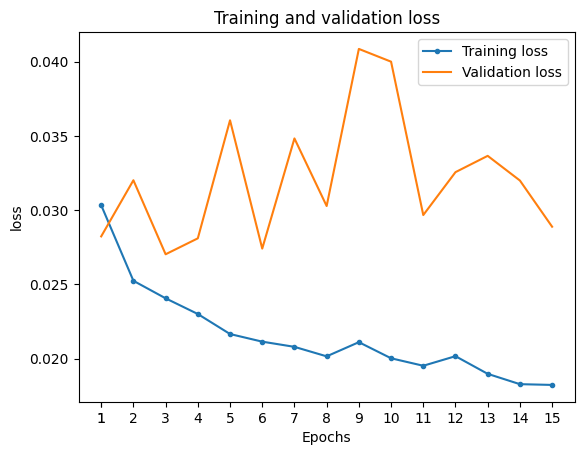

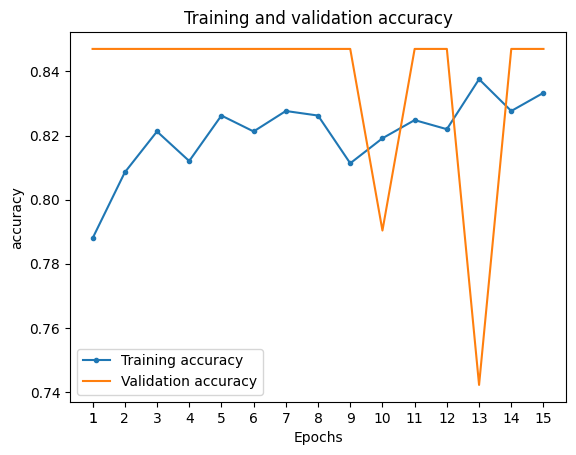


Eval scores:
14/14 [==============================] - 0s 18ms/step - loss: 0.0275 - accuracy: 0.8186
[0.41955253 0.12061094 0.6161907  0.33264953]


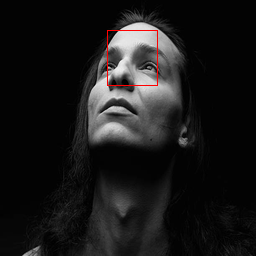

================ best-CNN_layers-19_opt-Adam_lr-0.001_default ================
batch_size: 32 | epoch: 15
Time to train model: 94.68 sec
Time to eval model: 0.72 sec


In [104]:
build_train_eval_plot(X_train, y_train, X_valid, y_valid, X_test, y_test, 'default', 32, 15, 'Adam', 0.001)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 dropout_76 (Dropout)        (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_76 (Bat  (None, 127, 127, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_77 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 dropout_77 (Dropout)        (None, 125, 125, 64)    

2023-05-30 15:57:58.491062: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_20/dropout_76/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/45 [============================>.] - ETA: 0s - loss: 0.0660 - accuracy: 0.6825
Epoch 1: val_loss improved from inf to 0.09850, saving model to checkpoints/best-CNN_layers-19_opt-Adam_lr-0.01_default.hdf5
45/45 [==============================] - 7s 147ms/step - loss: 0.0660 - accuracy: 0.6830 - val_loss: 0.0985 - val_accuracy: 0.8470
Epoch 2/15
44/45 [============================>.] - ETA: 0s - loss: 0.0288 - accuracy: 0.8161
Epoch 2: val_loss improved from 0.09850 to 0.02867, saving model to checkpoints/best-CNN_layers-19_opt-Adam_lr-0.01_default.hdf5
45/45 [==============================] - 6s 139ms/step - loss: 0.0288 - accuracy: 0.8149 - val_loss: 0.0287 - val_accuracy: 0.8470
Epoch 3/15
44/45 [============================>.] - ETA: 0s - loss: 0.0229 - accuracy: 0.8253
Epoch 3: val_loss improved from 0.02867 to 0.02330, saving model to checkpoints/best-CNN_layers-19_opt-Adam_lr-0.01_default.hdf5
45/45 [==============================] - 6s 139ms/step - loss: 0.0229 - accuracy: 0.

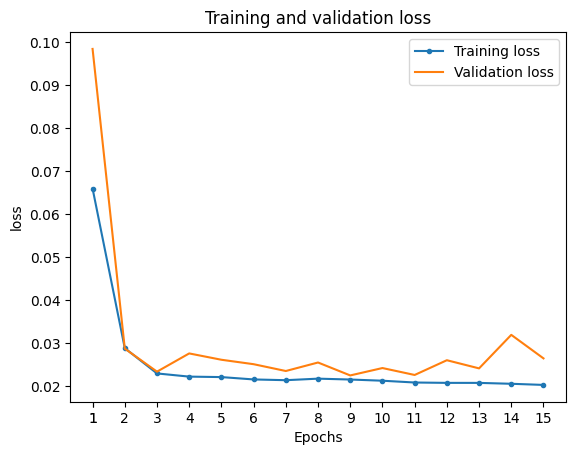

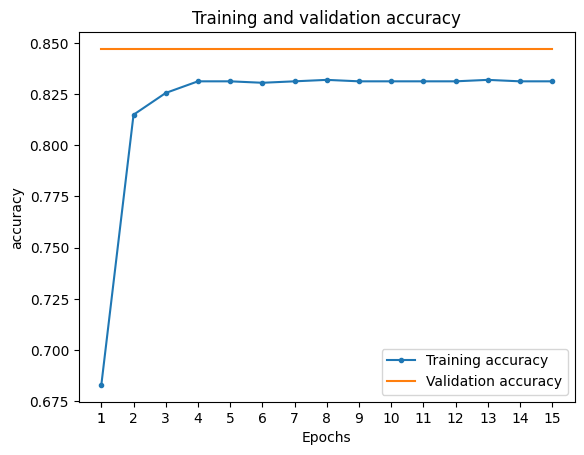


Eval scores:
14/14 [==============================] - 0s 18ms/step - loss: 0.0224 - accuracy: 0.8186
[0.39803657 0.11320497 0.61570823 0.40995127]


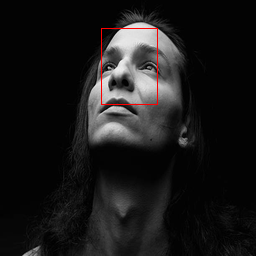

================ best-CNN_layers-19_opt-Adam_lr-0.01_default ================
batch_size: 32 | epoch: 15
Time to train model: 94.79 sec
Time to eval model: 0.72 sec


In [100]:
build_train_eval_plot(X_train, y_train, X_valid, y_valid, X_test, y_test, 'default', 32, 15, 'Adam', 0.01)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 dropout_8 (Dropout)         (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 127, 127, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 dropout_9 (Dropout)         (None, 125, 125, 64)     

2023-05-30 17:06:17.243669: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/45 [============================>.] - ETA: 0s - loss: 0.0672 - accuracy: 0.3068
Epoch 1: val_loss improved from inf to 0.06647, saving model to checkpoints/best-CNN_layers-19_opt-SGD_lr-0.001_default.hdf5
45/45 [==============================] - 7s 146ms/step - loss: 0.0672 - accuracy: 0.3064 - val_loss: 0.0665 - val_accuracy: 0.0000e+00
Epoch 2/15
44/45 [============================>.] - ETA: 0s - loss: 0.0605 - accuracy: 0.3722
Epoch 2: val_loss improved from 0.06647 to 0.06624, saving model to checkpoints/best-CNN_layers-19_opt-SGD_lr-0.001_default.hdf5
45/45 [==============================] - 6s 138ms/step - loss: 0.0605 - accuracy: 0.3716 - val_loss: 0.0662 - val_accuracy: 0.0000e+00
Epoch 3/15
44/45 [============================>.] - ETA: 0s - loss: 0.0552 - accuracy: 0.4119
Epoch 3: val_loss improved from 0.06624 to 0.06474, saving model to checkpoints/best-CNN_layers-19_opt-SGD_lr-0.001_default.hdf5
45/45 [==============================] - 6s 138ms/step - loss: 0.0553 - accu

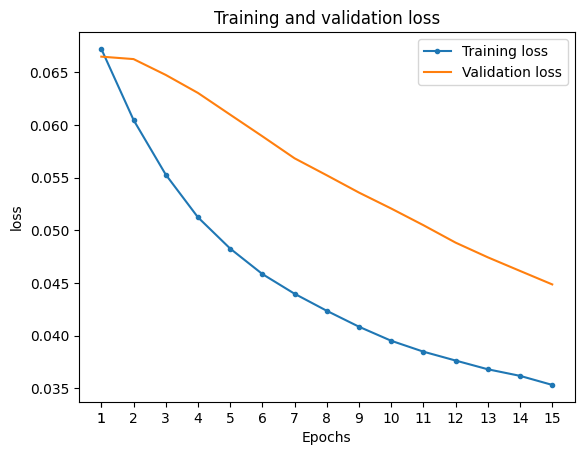

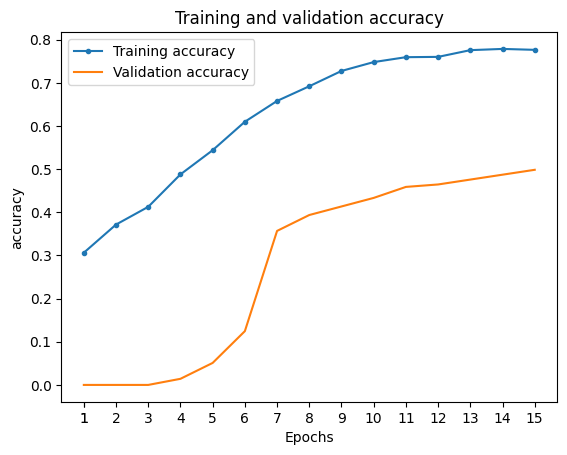


Eval scores:
14/14 [==============================] - 0s 18ms/step - loss: 0.0447 - accuracy: 0.5079
[0.44570327 0.40400204 0.59279704 0.5916012 ]


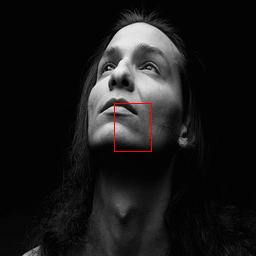

================ best-CNN_layers-19_opt-SGD_lr-0.001_default ================
batch_size: 32 | epoch: 15
Time to train model: 95.82 sec
Time to eval model: 0.73 sec


In [13]:
build_train_eval_plot(X_train, y_train, X_valid, y_valid, X_test, y_test, 'default', 32, 15, 'SGD', 0.001)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 dropout_92 (Dropout)        (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_92 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_92 (Bat  (None, 127, 127, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_93 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 dropout_93 (Dropout)        (None, 125, 125, 64)    

2023-05-30 16:13:09.564070: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_24/dropout_92/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/45 [============================>.] - ETA: 0s - loss: 0.0425 - accuracy: 0.7038
Epoch 1: val_loss improved from inf to 0.04506, saving model to checkpoints/best-CNN_layers-19_opt-SGD_lr-0.01_default.hdf5
45/45 [==============================] - 7s 146ms/step - loss: 0.0425 - accuracy: 0.7043 - val_loss: 0.0451 - val_accuracy: 0.1530
Epoch 2/15
44/45 [============================>.] - ETA: 0s - loss: 0.0320 - accuracy: 0.8068
Epoch 2: val_loss improved from 0.04506 to 0.03636, saving model to checkpoints/best-CNN_layers-19_opt-SGD_lr-0.01_default.hdf5
45/45 [==============================] - 6s 137ms/step - loss: 0.0320 - accuracy: 0.8071 - val_loss: 0.0364 - val_accuracy: 0.1530
Epoch 3/15
44/45 [============================>.] - ETA: 0s - loss: 0.0291 - accuracy: 0.8139
Epoch 3: val_loss improved from 0.03636 to 0.03290, saving model to checkpoints/best-CNN_layers-19_opt-SGD_lr-0.01_default.hdf5
45/45 [==============================] - 6s 137ms/step - loss: 0.0291 - accuracy: 0.813

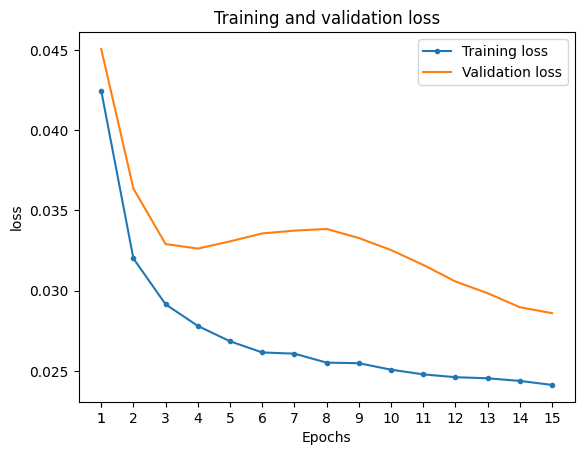

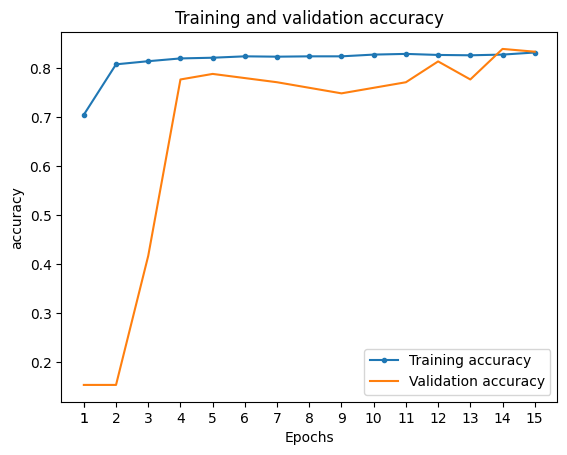


Eval scores:
14/14 [==============================] - 0s 18ms/step - loss: 0.0280 - accuracy: 0.8095
[0.28185177 0.1860996  0.6290981  0.60099226]


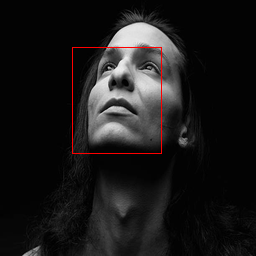

================ best-CNN_layers-19_opt-SGD_lr-0.01_default ================
batch_size: 32 | epoch: 15
Time to train model: 94.63 sec
Time to eval model: 0.72 sec


In [106]:
build_train_eval_plot(X_train, y_train, X_valid, y_valid, X_test, y_test, 'default', 32, 15, 'SGD', 0.01)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_96 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 dropout_96 (Dropout)        (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_96 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_96 (Bat  (None, 127, 127, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_97 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 dropout_97 (Dropout)        (None, 125, 125, 64)    

2023-05-30 16:15:28.676220: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_25/dropout_96/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/45 [============================>.] - ETA: 0s - loss: 0.0345 - accuracy: 0.7422
Epoch 1: val_loss improved from inf to 0.04221, saving model to checkpoints/best-CNN_layers-19_opt-RMSprop_lr-0.001_default.hdf5
45/45 [==============================] - 8s 147ms/step - loss: 0.0345 - accuracy: 0.7426 - val_loss: 0.0422 - val_accuracy: 0.8470
Epoch 2/15
44/45 [============================>.] - ETA: 0s - loss: 0.0277 - accuracy: 0.7898
Epoch 2: val_loss improved from 0.04221 to 0.03149, saving model to checkpoints/best-CNN_layers-19_opt-RMSprop_lr-0.001_default.hdf5
45/45 [==============================] - 6s 137ms/step - loss: 0.0276 - accuracy: 0.7901 - val_loss: 0.0315 - val_accuracy: 0.8470
Epoch 3/15
44/45 [============================>.] - ETA: 0s - loss: 0.0258 - accuracy: 0.8011
Epoch 3: val_loss did not improve from 0.03149
45/45 [==============================] - 6s 137ms/step - loss: 0.0258 - accuracy: 0.8007 - val_loss: 0.0688 - val_accuracy: 0.0000e+00
Epoch 4/15
44/45 [=====

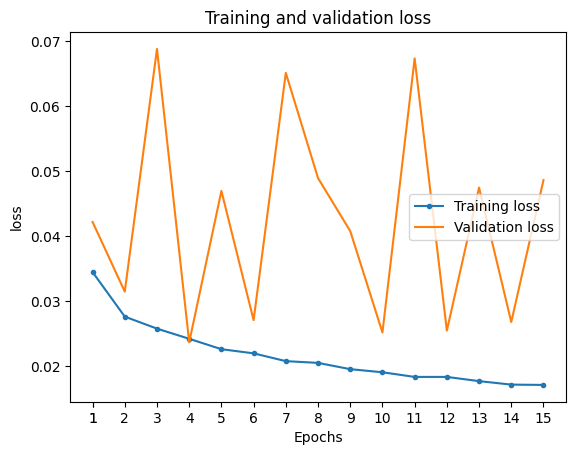

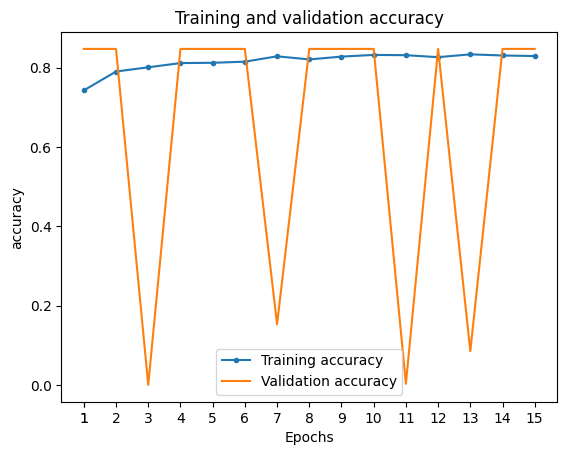


Eval scores:
14/14 [==============================] - 0s 18ms/step - loss: 0.0235 - accuracy: 0.8186
[0.39115345 0.10915777 0.6646608  0.46862805]


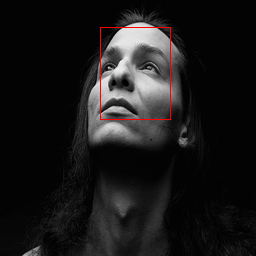

================ best-CNN_layers-19_opt-RMSprop_lr-0.001_default ================
batch_size: 32 | epoch: 15
Time to train model: 95.36 sec
Time to eval model: 0.72 sec


In [107]:
build_train_eval_plot(X_train, y_train, X_valid, y_valid, X_test, y_test, 'default', 32, 15, 'RMSprop', 0.001)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 254, 254, 32)      320       
                                                                 
 dropout_100 (Dropout)       (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_100 (MaxPooli  (None, 127, 127, 32)     0         
 ng2D)                                                           
                                                                 
 batch_normalization_100 (Ba  (None, 127, 127, 32)     128       
 tchNormalization)                                               
                                                                 
 conv2d_101 (Conv2D)         (None, 125, 125, 64)      18496     
                                                                 
 dropout_101 (Dropout)       (None, 125, 125, 64)    

2023-05-30 16:17:05.614039: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_26/dropout_100/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/45 [============================>.] - ETA: 0s - loss: 0.0800 - accuracy: 0.7060
Epoch 1: val_loss improved from inf to 0.04592, saving model to checkpoints/best-CNN_layers-19_opt-RMSprop_lr-0.01_default.hdf5
45/45 [==============================] - 8s 147ms/step - loss: 0.0799 - accuracy: 0.7057 - val_loss: 0.0459 - val_accuracy: 0.8470
Epoch 2/15
44/45 [============================>.] - ETA: 0s - loss: 0.0281 - accuracy: 0.8097
Epoch 2: val_loss improved from 0.04592 to 0.03667, saving model to checkpoints/best-CNN_layers-19_opt-RMSprop_lr-0.01_default.hdf5
45/45 [==============================] - 6s 138ms/step - loss: 0.0280 - accuracy: 0.8099 - val_loss: 0.0367 - val_accuracy: 0.8470
Epoch 3/15
44/45 [============================>.] - ETA: 0s - loss: 0.0232 - accuracy: 0.8317
Epoch 3: val_loss improved from 0.03667 to 0.02579, saving model to checkpoints/best-CNN_layers-19_opt-RMSprop_lr-0.01_default.hdf5
45/45 [==============================] - 6s 137ms/step - loss: 0.0232 - acc

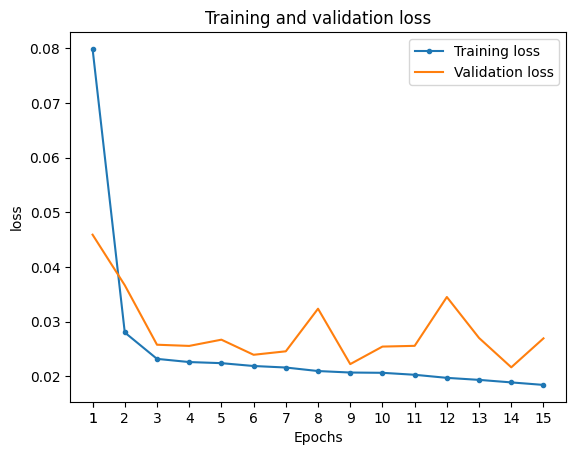

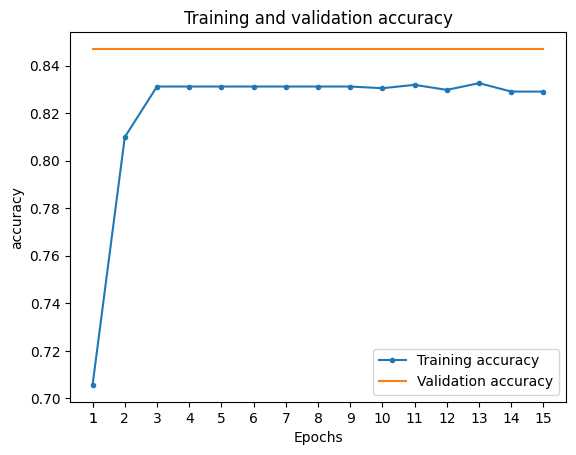


Eval scores:
14/14 [==============================] - 0s 18ms/step - loss: 0.0213 - accuracy: 0.8186
[0.29560146 0.09168994 0.7300441  0.5728939 ]


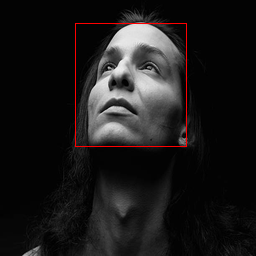

================ best-CNN_layers-19_opt-RMSprop_lr-0.01_default ================
batch_size: 32 | epoch: 15
Time to train model: 93.97 sec
Time to eval model: 0.72 sec


In [108]:
build_train_eval_plot(X_train, y_train, X_valid, y_valid, X_test, y_test, 'default', 32, 15, 'RMSprop', 0.01)

In [9]:
def model_CNN(height: int, width: int):
    model = Sequential()
    model.add(Conv2D(64, 3, input_shape=(height, width, 1), activation='relu'))  # Increase the number of filters
    model.add(Dropout(0.1))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(128, 3, activation='relu'))  # Increase the number of filters
    model.add(Dropout(0.2))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(256, 3, activation='relu'))  # Increase the number of filters
    model.add(Dropout(0.3))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(512, 3, activation='relu'))  # Increase the number of filters
    model.add(Dropout(0.4))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation = 'relu'))  # Increase the number of neurons in the dense layer
    model.add(Dense(4, activation = 'sigmoid'))
    return model

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_113 (Conv2D)         (None, 254, 254, 64)      640       
                                                                 
 dropout_113 (Dropout)       (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d_113 (MaxPooli  (None, 127, 127, 64)     0         
 ng2D)                                                           
                                                                 
 batch_normalization_113 (Ba  (None, 127, 127, 64)     256       
 tchNormalization)                                               
                                                                 
 conv2d_114 (Conv2D)         (None, 125, 125, 128)     73856     
                                                                 
 dropout_114 (Dropout)       (None, 125, 125, 128)   

2023-05-30 16:44:54.301912: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_29/dropout_113/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/45 [============================>.] - ETA: 0s - loss: 0.1500 - accuracy: 0.7692
Epoch 1: val_loss improved from inf to 0.14910, saving model to checkpoints/best-CNN_layers-19_opt-RMSprop_lr-0.01_default.hdf5
45/45 [==============================] - 15s 317ms/step - loss: 0.1500 - accuracy: 0.7688 - val_loss: 0.1491 - val_accuracy: 0.8470
Epoch 2/15
44/45 [============================>.] - ETA: 0s - loss: 0.1479 - accuracy: 0.7869
Epoch 2: val_loss improved from 0.14910 to 0.07870, saving model to checkpoints/best-CNN_layers-19_opt-RMSprop_lr-0.01_default.hdf5
45/45 [==============================] - 14s 309ms/step - loss: 0.1478 - accuracy: 0.7872 - val_loss: 0.0787 - val_accuracy: 0.6714
Epoch 3/15
44/45 [============================>.] - ETA: 0s - loss: 0.0539 - accuracy: 0.8075
Epoch 3: val_loss did not improve from 0.07870
45/45 [==============================] - 13s 299ms/step - loss: 0.0539 - accuracy: 0.8078 - val_loss: 0.1473 - val_accuracy: 0.8470
Epoch 4/15
44/45 [========

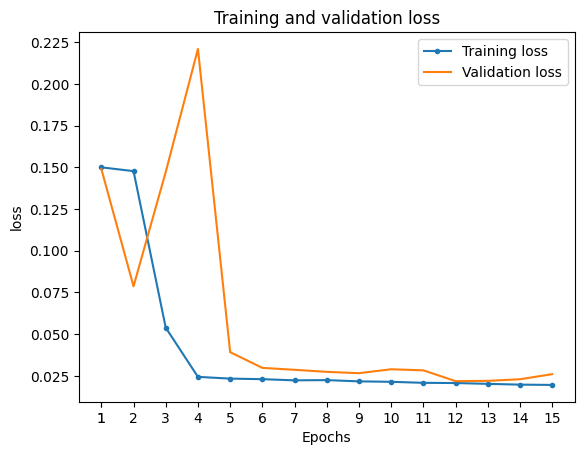

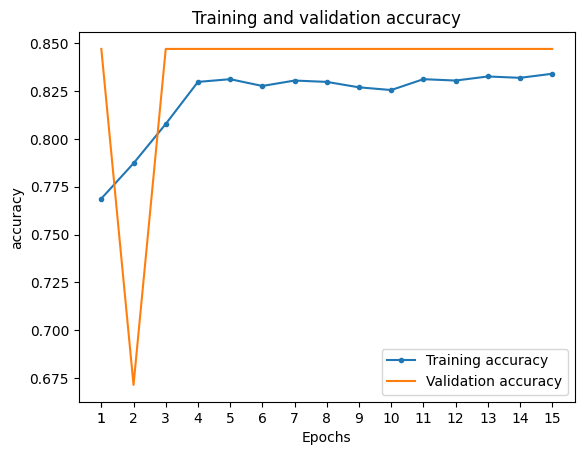


Eval scores:
14/14 [==============================] - 1s 39ms/step - loss: 0.0216 - accuracy: 0.8186
[0.36265218 0.15277515 0.6682418  0.5219651 ]


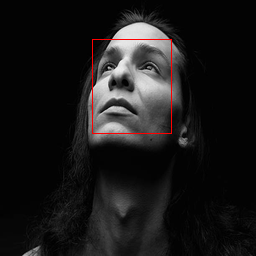

================ best-CNN_layers-19_opt-RMSprop_lr-0.01_default ================
batch_size: 32 | epoch: 15
Time to train model: 203.08 sec
Time to eval model: 1.04 sec


In [114]:
build_train_eval_plot(X_train, y_train, X_valid, y_valid, X_test, y_test, 'more_complex', 32, 15, 'RMSprop', 0.01)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      640       
                                                                 
 dropout (Dropout)           (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 dropout_1 (Dropout)         (None, 125, 125, 128)     0

2023-05-30 16:57:36.232478: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-30 16:57:36.235480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-30 16:57:36.238351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/15


2023-05-30 16:57:42.622833: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-30 16:57:43.810152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900


45/45 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.6617
Epoch 1: val_loss improved from inf to 0.16206, saving model to checkpoints/best-CNN_layers-19_opt-Adam_lr-0.01_more_complex.hdf5
45/45 [==============================] - 22s 338ms/step - loss: 0.1354 - accuracy: 0.6617 - val_loss: 0.1621 - val_accuracy: 0.8215
Epoch 2/15
44/45 [============================>.] - ETA: 0s - loss: 0.0916 - accuracy: 0.6612
Epoch 2: val_loss improved from 0.16206 to 0.07061, saving model to checkpoints/best-CNN_layers-19_opt-Adam_lr-0.01_more_complex.hdf5
45/45 [==============================] - 14s 312ms/step - loss: 0.0915 - accuracy: 0.6617 - val_loss: 0.0706 - val_accuracy: 0.8215
Epoch 3/15
44/45 [============================>.] - ETA: 0s - loss: 0.0285 - accuracy: 0.8139
Epoch 3: val_loss improved from 0.07061 to 0.02396, saving model to checkpoints/best-CNN_layers-19_opt-Adam_lr-0.01_more_complex.hdf5
45/45 [==============================] - 14s 313ms/step - loss: 0.0

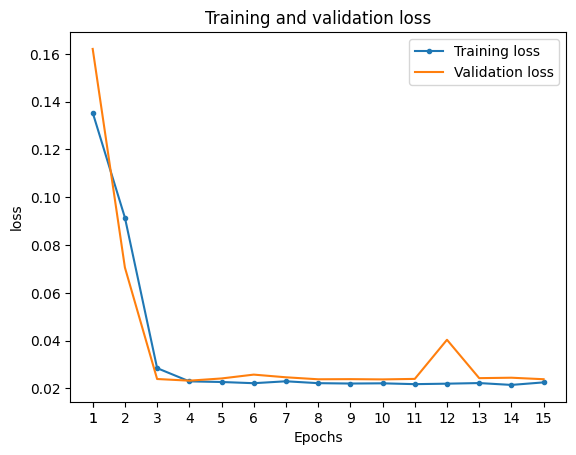

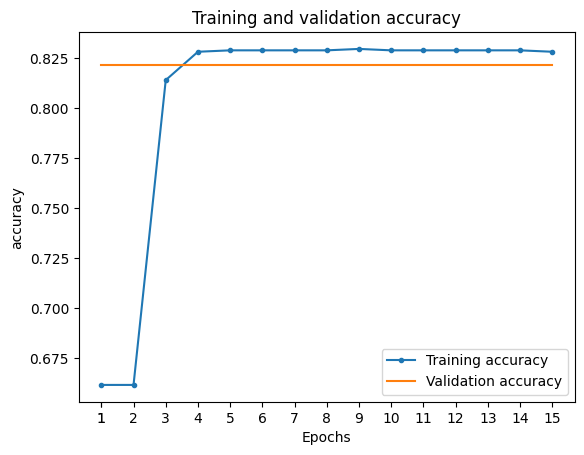


Eval scores:
14/14 [==============================] - 2s 142ms/step - loss: 0.0216 - accuracy: 0.8458
[0.39419004 0.21563467 0.6016331  0.4494127 ]


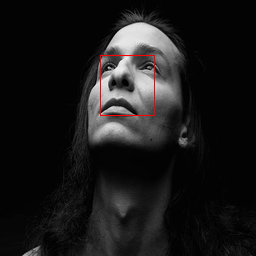

================ best-CNN_layers-19_opt-Adam_lr-0.01_more_complex ================
batch_size: 32 | epoch: 15
Time to train model: 219.23 sec
Time to eval model: 2.36 sec


In [10]:
build_train_eval_plot(X_train, y_train, X_valid, y_valid, X_test, y_test, 'more_complex', 32, 15, 'Adam', 0.01)

In [18]:
stats = pd.DataFrame({
    'optimizer': ['Adam', 'Adam', 'SGD', 'SGD', 'RMSprop', 'RMSprop', 'RMSprop', 'Adam'],
    'lr': [0.001, 0.01, 0.001, 0.01, 0.001, 0.01, 0.01, 0.01],
    'loss': [0.0275, 0.0224, 0.0447, 0.028, 0.0235, 0.0213, 0.0216, 0.0216],
    'accuracy': [0.8186, 0.8186, 0.5079, 0.8095, 0.8186, 0.8186, 0.8186, 0.8458],
    'batch_size': [32] * 8,
    'epochs': [15] * 8,
    'nn_architecture': ['default'] * 6 + ['more_complex'] * 2,
    'time_eval': [0.72, 0.72, 0.73, 0.72, 0.72, 0.72, 1.04, 2.36],
    'time_train': [94.68, 94.79, 95.82, 94.63, 95.36, 93.97, 203.08, 219.23]
})

In [24]:
stats.sort_values(by=['accuracy', 'loss', 'time_train', 'time_eval'], ascending=[False, True, True, True])

,optimizer,lr,loss,accuracy,batch_size,epochs,nn_architecture,time_eval,time_train
7,Adam,0.010,0.0216,0.8458,32,15,more_complex,2.36,219.23
5,RMSprop,0.010,0.0213,0.8186,32,15,default,0.72,93.97
6,RMSprop,0.010,0.0216,0.8186,32,15,more_complex,1.04,203.08
1,Adam,0.010,0.0224,0.8186,32,15,default,0.72,94.79
4,RMSprop,0.001,0.0235,0.8186,32,15,default,0.72,95.36
0,Adam,0.001,0.0275,0.8186,32,15,default,0.72,94.68
3,SGD,0.010,0.0280,0.8095,32,15,default,0.72,94.63
2,SGD,0.001,0.0447,0.5079,32,15,default,0.73,95.82
